<a href="https://colab.research.google.com/github/YuHsin-Chen1221/Computational-Pathology/blob/main/Breast_Histopathology_IDC_Diagnosis_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download alaminbhuyan/breast-histopathology-images

Dataset URL: https://www.kaggle.com/datasets/alaminbhuyan/breast-histopathology-images
License(s): unknown
 86% 797M/929M [00:00<00:00, 1.39GB/s]
100% 929M/929M [00:00<00:00, 1.37GB/s]


In [3]:
! unzip breast-histopathology-images.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: IDC_regular_ps50_idx5/positive_IDC/9259_idx5_x2601_y1051_class1.png  
  inflating: IDC_regular_ps50_idx5/positive_IDC/9259_idx5_x2601_y1101_class1.png  
  inflating: IDC_regular_ps50_idx5/positive_IDC/9259_idx5_x2601_y1151_class1.png  
  inflating: IDC_regular_ps50_idx5/positive_IDC/9259_idx5_x2601_y851_class1.png  
  inflating: IDC_regular_ps50_idx5/positive_IDC/9259_idx5_x2601_y901_class1.png  
  inflating: IDC_regular_ps50_idx5/positive_IDC/9259_idx5_x2601_y951_class1.png  
  inflating: IDC_regular_ps50_idx5/positive_IDC/9259_idx5_x2651_y1001_class1.png  
  inflating: IDC_regular_ps50_idx5/positive_IDC/9259_idx5_x2651_y1051_class1.png  
  inflating: IDC_regular_ps50_idx5/positive_IDC/9259_idx5_x2651_y1101_class1.png  
  inflating: IDC_regular_ps50_idx5/positive_IDC/9259_idx5_x2651_y851_class1.png  
  inflating: IDC_regular_ps50_idx5/positive_IDC/9259_idx5_x2651_y901_class1.png  
  inflating: IDC_regular_ps50_idx5/positive_IDC/9259_idx5_x2651_y951_cl

🔵 Negative samples: 78786
🔴 Positive samples (IDC): 78786


/tmp/ipython-input-4-635966732.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Negative (Class 0)", "Positive (Class 1)"],


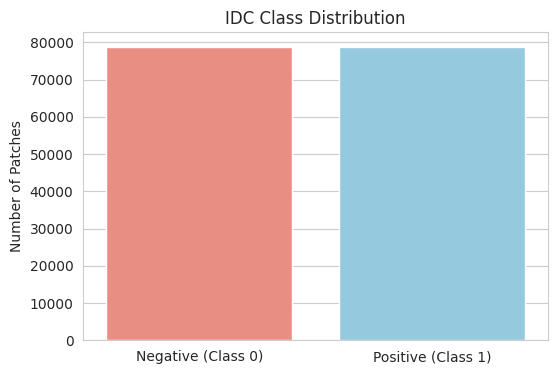

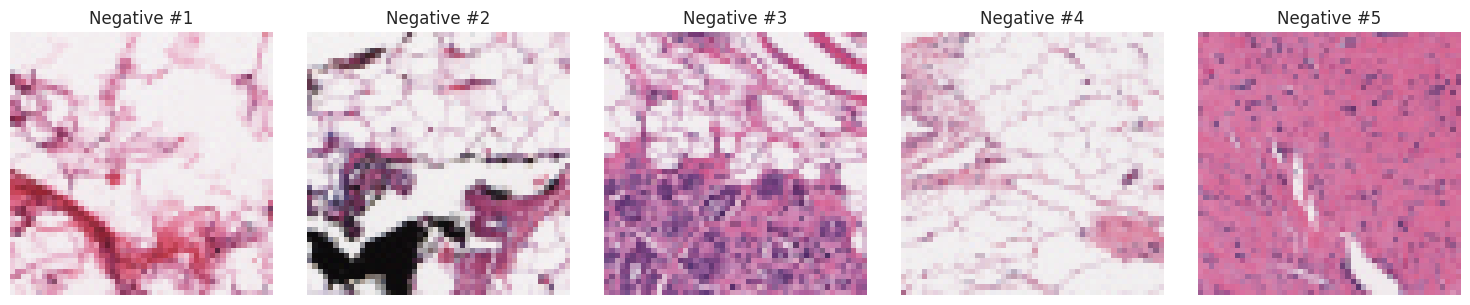

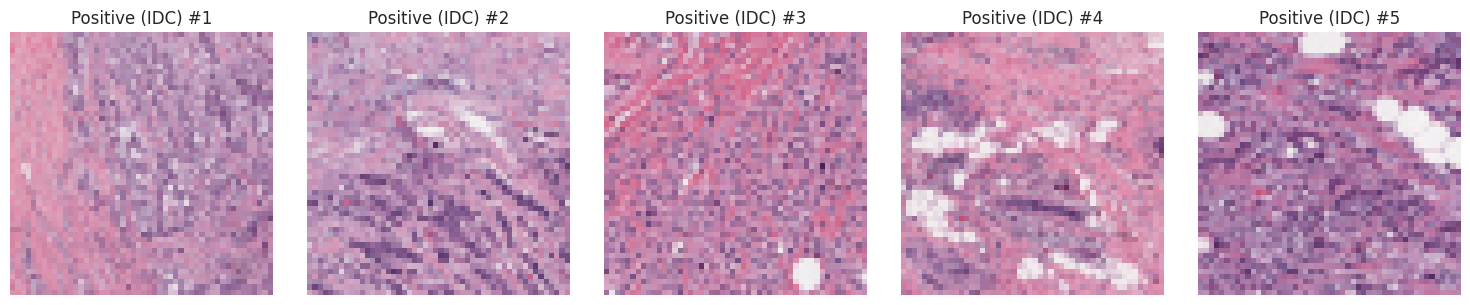

In [4]:
# data loading & EDA
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

dir_path = "/content/IDC_regular_ps50_idx5"

negative_dir = os.path.join(dir_path, "negative_IDC")
positive_dir = os.path.join(dir_path, "positive_IDC")

neg_imgs = [f for f in os.listdir(negative_dir) if f.endswith(".png")]
pos_imgs = [f for f in os.listdir(positive_dir) if f.endswith(".png")]

print(f"🔵 Negative samples: {len(neg_imgs)}")
print(f"🔴 Positive samples (IDC): {len(pos_imgs)}")

# IDC samples distribution
sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
sns.barplot(x=["Negative (Class 0)", "Positive (Class 1)"],
            y=[len(neg_imgs), len(pos_imgs)],
            palette=["salmon", "skyblue"])
plt.title("IDC Class Distribution")
plt.ylabel("Number of Patches")
plt.show()

# intances visualize
def show_random_images(folder_path, title, num=5):
    all_files = os.listdir(folder_path)
    selected_files = random.sample(all_files, num)

    plt.figure(figsize=(15, 3))
    for i, file in enumerate(selected_files):
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path)
        plt.subplot(1, num, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{title} #{i+1}")
    plt.tight_layout()
    plt.show()

show_random_images(negative_dir, "Negative", num=5)
show_random_images(positive_dir, "Positive (IDC)", num=5)

In [5]:
! pip install opencv-python scikit-image albumentations

In [6]:
# data pre-processing & feature engineering

  # Stain Normalization (Macenko's Method)

from skimage import exposure, img_as_ubyte
import numpy as np
import cv2

def stain_normalization(img):
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img)
    l = cv2.equalizeHist(l)
    img = cv2.merge((l, a, b))
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return Image.fromarray(img)

  # Color Deconvolution (Separate Hematoxylin/Eosin)

from skimage.color import separate_stains, hed_from_rgb

def color_deconvolution(img):
    img_np = np.array(img)
    deconv = separate_stains(img_np, hed_from_rgb)
    # Only return the Hematoxylin channel (nuclei)
    hema = deconv[:, :, 0]
    return Image.fromarray(img_as_ubyte(exposure.rescale_intensity(hema)))

  # Patch Filtering (Remove Background/Low Tissue)

def patch_filtering(img, threshold=0.8):
    img_np = np.array(img.convert("L"))  # grayscale
    white_ratio = np.sum(img_np > 220) / img_np.size
    return white_ratio < threshold


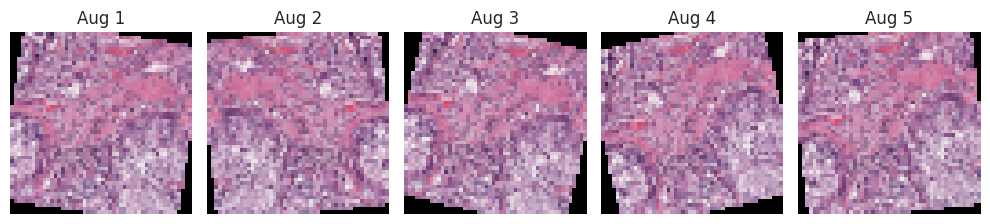

In [7]:
# data augmentation

import torchvision.transforms as transforms
from torchvision.transforms import functional as F

def get_transforms(augment=False):
    if augment:
        return transforms.Compose([
            transforms.Resize((50, 50)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),  # will keep 3 channels if input is RGB
        ])
    else:
        return transforms.Compose([
            transforms.Resize((50, 50)),
            transforms.ToTensor(),
        ])

# Test on an example image
test_img = Image.open(os.path.join(positive_dir, pos_imgs[0]))
aug_transform = get_transforms(augment=True)

plt.figure(figsize=(10, 3))
for i in range(5):
    transformed_img = aug_transform(test_img)
    plt.subplot(1, 5, i + 1)
    plt.imshow(transformed_img.permute(1, 2, 0))  # convert CxHxW to HxWxC
    plt.axis("off")
    plt.title(f"Aug {i+1}")
plt.tight_layout()
plt.show()


In [8]:

def preprocess_and_augment_image(img_raw, augment_transforms):
    img_normalized = stain_normalization(img_raw)
    img_deconvolved = color_deconvolution(img_normalized)

    if augment_transforms:
        return augment_transforms(img_deconvolved)
    else:
        base_transforms = get_transforms(augment=False)
        return base_transforms(img_deconvolved)

# Load & preprocess images only once
processed_images = []
processed_labels = []

augment_transforms = get_transforms(augment=True)

for f in pos_imgs:
    img_path = os.path.join(positive_dir, f)
    img_raw = Image.open(img_path).convert("RGB")
    if not patch_filtering(img_raw): continue
    img_tensor = preprocess_and_augment_image(img_raw, augment_transforms)
    processed_images.append(img_tensor)
    processed_labels.append(1)

for f in neg_imgs:
    img_path = os.path.join(negative_dir, f)
    img_raw = Image.open(img_path).convert("RGB")
    if not patch_filtering(img_raw): continue
    img_tensor = preprocess_and_augment_image(img_raw, augment_transforms)
    processed_images.append(img_tensor)
    processed_labels.append(0)

print(f"✅ Total: {len(processed_images)} | Pos: {processed_labels.count(1)} | Neg: {processed_labels.count(0)}")



✅ Total: 154650 | Pos: 78499 | Neg: 76151


In [11]:
# Save tensors and labels as a tuple
import torch
from torch.utils.data import Dataset, DataLoader, random_split

torch.save((processed_images, processed_labels), 'processed_data.pt')
processed_images, processed_labels = torch.load('processed_data.pt')

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    processed_images, processed_labels, test_size=0.2, stratify=processed_labels, random_state=42
)

from torch.utils.data import Dataset, DataLoader

class BreastCancerDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], torch.tensor(self.labels[idx], dtype=torch.long)

# Wrap into Dataset
train_dataset = BreastCancerDataset(X_train, y_train)
val_dataset = BreastCancerDataset(X_val, y_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [17]:
# model building
import torch
import torch.nn as nn
import torch.nn.functional as F

class IDCClassifier(nn.Module):
    def __init__(self):
        super(IDCClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(32 * 12 * 12, 64)  # Based on input image size 50x50 → 25x25 → 12x12 after two poolings
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # → [16x25x25]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # → [32x12x12]
        x = x.view(-1, 32 * 12 * 12)
        x = self.dropout(F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))  # Binary classification
        return x

model = IDCClassifier()
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class IDCClassifier(nn.Module):
    def __init__(self):
        super(IDCClassifier, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (1, 50, 50) → (32, 50, 50)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (32, 25, 25)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (64, 12, 12)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (128, 6, 6)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(128 * 6 * 6, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x  # Use BCEWithLogitsLoss, so sigmoid not applied here

model = IDCClassifier()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # Slightly smaller LR often works better


In [25]:
import torch.cuda.amp as amp

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize the scaler for mixed precision training
scaler = amp.GradScaler()

num_epochs = 10

train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

for epoch in range(num_epochs):
    # ----- Training -----
    model.train()
    total_train_loss = 0
    correct_train = 0

    for inputs, labels in train_loader:
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Use mixed precision
        with amp.autocast():
            outputs = model(inputs)
            labels = labels.view(-1, 1).float()
            loss = criterion(outputs, labels)

        # Scale the loss and call backward()
        scaler.scale(loss).backward()
        # Update model parameters
        scaler.step(optimizer)
        # Updates the scale for next iteration
        scaler.update()


        total_train_loss += loss.item()
        predicted = (outputs > 0.5).squeeze().long()
        correct_train += (predicted == labels.squeeze().long()).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / len(train_dataset)
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_acc)

    # ----- Validation -----
    model.eval()
    total_val_loss = 0
    correct_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Use mixed precision
            with amp.autocast():
                outputs = model(inputs)
                labels = labels.view(-1, 1).float()
                loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            predicted = (outputs > 0.5).squeeze().long()
            correct_val += (predicted == labels.squeeze().long()).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / len(val_dataset)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


/tmp/ipython-input-25-3394001192.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
/tmp/ipython-input-25-3394001192.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipython-input-25-3394001192.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [1/10] | Train Loss: 0.4803 | Train Acc: 0.7610 | Val Loss: 0.4501 | Val Acc: 0.7977
Epoch [2/10] | Train Loss: 0.4484 | Train Acc: 0.7841 | Val Loss: 0.4678 | Val Acc: 0.7215
Epoch [3/10] | Train Loss: 0.4367 | Train Acc: 0.7912 | Val Loss: 0.4181 | Val Acc: 0.7893
Epoch [4/10] | Train Loss: 0.4274 | Train Acc: 0.7963 | Val Loss: 0.4140 | Val Acc: 0.8127
Epoch [5/10] | Train Loss: 0.4207 | Train Acc: 0.8025 | Val Loss: 0.4244 | Val Acc: 0.8182
Epoch [6/10] | Train Loss: 0.4144 | Train Acc: 0.8045 | Val Loss: 0.5536 | Val Acc: 0.6682
Epoch [7/10] | Train Loss: 0.4078 | Train Acc: 0.8100 | Val Loss: 0.4211 | Val Acc: 0.8172
Epoch [8/10] | Train Loss: 0.4024 | Train Acc: 0.8113 | Val Loss: 0.4005 | Val Acc: 0.8144
Epoch [9/10] | Train Loss: 0.3978 | Train Acc: 0.8144 | Val Loss: 0.3973 | Val Acc: 0.8142
Epoch [10/10] | Train Loss: 0.3933 | Train Acc: 0.8167 | Val Loss: 0.3972 | Val Acc: 0.8166


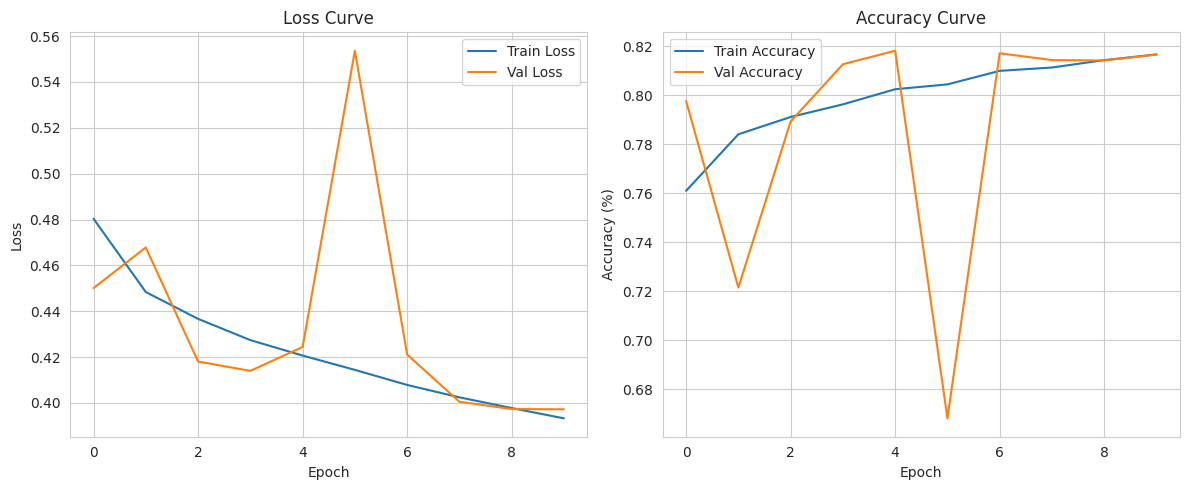

In [26]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()
